<a href="https://colab.research.google.com/github/divyabala-ai/nli-multilingual-classifier/blob/main/nli_multilingual_bert_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLI - Watson Project**

Using the dataset from Kaggle: Contradictory, My Dear Watson, build a classification model to predict if the two sentences are in entailment, neutral, or contradiction.

The project should follow the guidelines below:

1.  Pre-process the data
2.  Perform data exploration
3.  Use BERT to build the model, including generating the classification report
4.  Use GPT to build the model
5.  Use Ollama to build the model
6.  Write up analysis and conclusions












In [ ]:
# !pip install datasets

In [ ]:
# === Imports ===
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report
from transformers import Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification #BertTokenizer, BertForSequenceClassification,

# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# **Data pre-processing**

In [ ]:
# Load raw train and test data
raw_train_df = pd.read_csv('/content/drive/MyDrive/nli_watson/train.csv') # raw_train_df - untouched reference
raw_test_df = pd.read_csv('/content/drive/MyDrive/nli_watson/test.csv')   # raw_test_df - untouched reference

# Make working copies (preserve raw versions)
train_df = raw_train_df.copy()
test_df = raw_test_df.copy()

# Cleaning function
def clean_nli_dataframe(df):
    # Check if 'label' column exists before filtering
    if 'label' in df.columns:
        df = df.dropna()                                                     # Drop missing values
        df = df.drop_duplicates(subset=['premise', 'hypothesis'])            # Remove duplicates
        df = df.reset_index(drop=True)                                       # Reset index
        return df[['premise', 'hypothesis', 'label']]                        # Keep relevant columns from train data
    else:
        # If 'label' column doesn't exist, assume it's the test set
        df = df.dropna()                                                     # Drop missing values
        df = df.drop_duplicates(subset=['premise', 'hypothesis'])            # Remove duplicates
        df = df.reset_index(drop=True)                                       # Reset index
        return df[['premise', 'hypothesis']]                                 # Keep relevant columns from test data

# Cleaned copies for modeling
clean_train_df = clean_nli_dataframe(train_df)
clean_test_df = clean_nli_dataframe(test_df)

# **Exploratory Data Analysis (EDA)**

In [ ]:
# Check overall structure
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     12120 non-null  object
 1   hypothesis  12120 non-null  object
 2   label       12120 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 284.2+ KB


In [ ]:
# View random samples
clean_train_df.sample(5)

,premise,hypothesis,label
5604,Не обръщайте внимание на въпроса дали индексът...,Dow Jones показва какво се случва в икономиката.,0
5941,"Territorial rights, in the form of a deck chai...",You have no territorial rights with a deck chair.,2
1635,Such multicolored reef dwellers as the parrotf...,It's often hard to see turtles because they ar...,1
9447,Built in a.d. 715 to help measure the peak and...,It said the Nile flood was 12 feet deep.,1
6279,"'We can't find him, Benjamin,' Lincoln/Natalia...","After 12 hours looking for him, Lincoln/Natali...",1


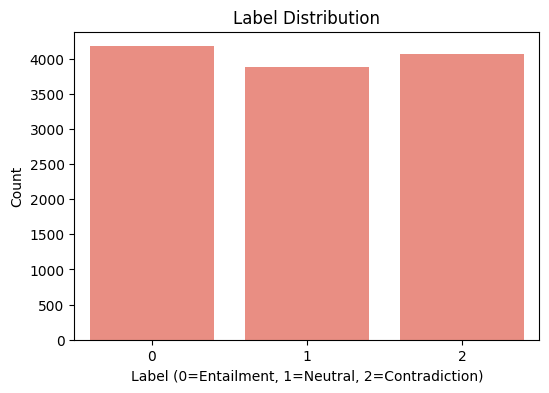

In [ ]:
# Label Distribution - to detect class imbalance
plt.figure(figsize=(6,4))
sns.countplot(data=clean_train_df, x='label', color='salmon')
plt.title("Label Distribution")
plt.xlabel("Label (0=Entailment, 1=Neutral, 2=Contradiction)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Sentence Length Statistics - Helps determine if you’ll need truncation or padding for models like BERT.
clean_train_df['premise_len'] = clean_train_df['premise'].apply(lambda x: len(x.split()))
clean_train_df['hypothesis_len'] = clean_train_df['hypothesis'].apply(lambda x: len(x.split()))

print(clean_train_df[['premise_len', 'hypothesis_len']].describe())

        premise_len  hypothesis_len
count  12120.000000    12120.000000
mean      17.990182        9.195297
std       12.898411        4.650281
min        1.000000        1.000000
25%        9.000000        6.000000
50%       16.000000        9.000000
75%       25.000000       12.000000
max      196.000000       46.000000


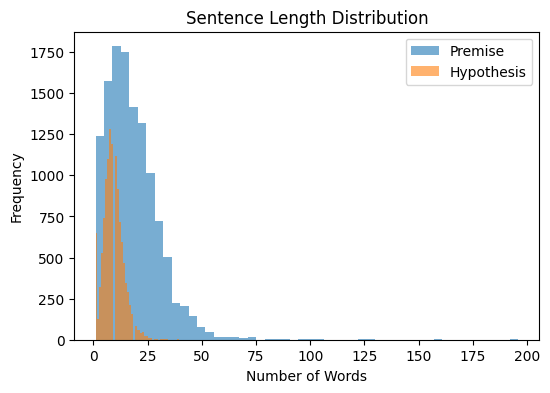

In [ ]:
# Visualize typical sentence lengths
plt.figure(figsize=(6,4))
plt.hist(clean_train_df['premise_len'], bins=50, alpha=0.6, label='Premise')
plt.hist(clean_train_df['hypothesis_len'], bins=50, alpha=0.6, label='Hypothesis')
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# **Build the NLI model using BERT**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# ✅ Load XLM-R tokenizer (multilingual)
tokenizer_bert = AutoTokenizer.from_pretrained('xlm-roberta-base')

# ✅ Tokenization function
def tokenize_batch_bert(batch):
    return tokenizer_bert(batch['premise'], batch['hypothesis'], padding='max_length', truncation='only_first', max_length=128)

# ✅ Convert cleaned DataFrames to Hugging Face Datasets
train_dataset_bert = Dataset.from_pandas(clean_train_df)
test_dataset_bert = Dataset.from_pandas(clean_test_df)

# ✅ Tokenize both datasets
train_dataset_bert = train_dataset_bert.map(tokenize_batch_bert, batched=True)
test_dataset_bert = test_dataset_bert.map(tokenize_batch_bert, batched=True)

# ✅ Add labels explicitly (only for training data)
train_dataset_bert = train_dataset_bert.map(lambda x: {'labels': x['label']}, batched=True)

# ✅ Train/validation split from training dataset
train_ds_bert, val_ds_bert = train_dataset_bert.train_test_split(test_size=0.1, seed=42).values()

# ✅ Load multilingual model for sequence classification
model_bert = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=3)

# ✅ Define compute_metrics for accuracy
def compute_metrics_bert(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# ✅ Training arguments
training_arguments_bert = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=1e-5,
    warmup_ratio=0.03,
    weight_decay=0.05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=50,
    logging_strategy="steps",
    report_to="none",
)

# ✅ Instantiate Trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_arguments_bert,
    train_dataset=train_ds_bert,
    eval_dataset=val_ds_bert,
    compute_metrics=compute_metrics_bert,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# ✅ Train the model
trainer_bert.train()

# ✅ Evaluate on validation set
true_labels = val_ds_bert['labels']
predictions_bert = trainer_bert.predict(val_ds_bert).predictions
predicted_labels_bert = predictions_bert.argmax(axis=1)

print("Classification Report for Validation Data - XLM-RoBERTa:")
print(classification_report(true_labels, predicted_labels_bert))

# ✅ Predict on test dataset
predictions_bert = trainer_bert.predict(test_dataset_bert).predictions
predicted_labels_bert = predictions_bert.argmax(axis=1)

# ✅ Create output dataframe
clean_test_df_bert = clean_test_df.copy()
clean_test_df_bert['predicted_label'] = predicted_labels_bert

# ✅ Preview predictions
print(clean_test_df_bert[['premise', 'hypothesis', 'predicted_label']].head())


Map:   0%|          | 0/12120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

Map:   0%|          | 0/12120 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.905100,0.802915,0.640264
2,0.749700,0.662885,0.729373
3,0.630300,0.662860,0.745050
4,0.515100,0.677091,0.753300


Classification Report for Validation Data - XLM-RoBERTa:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       423
           1       0.65      0.75      0.70       366
           2       0.79      0.71      0.75       423

    accuracy                           0.75      1212
   macro avg       0.75      0.75      0.74      1212
weighted avg       0.75      0.75      0.75      1212



                                             premise  \
0  بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...   
1                             هذا هو ما تم نصحنا به.   
2  et cela est en grande partie dû au fait que le...   
3                   与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp   
4                              Она все еще была там.   

                                          hypothesis  predicted_label  
0  کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...                1  
1  عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...                1  
2                             Les mères se droguent.                0  
3                            IMA与其他组织合作，因为它们都依靠共享资金。                1  
4     Мы думали, что она ушла, однако, она осталась.                0  


# **Build the NLI model using GPT**





In [ ]:
# Fine-tune training arguments
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AutoConfig, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import numpy as np

# ✅ Load tokenizer from gpt2-medium
tokenizer_gpt = GPT2Tokenizer.from_pretrained("gpt2-medium")
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

# ✅ Load model config from gpt2-medium
config_gpt = AutoConfig.from_pretrained("gpt2-medium", num_labels=3, pad_token_id=tokenizer_gpt.pad_token_id)

# ✅ New prompt format for better task understanding
def tokenize_batch_gpt(batch):
    prompt = [
        f"Premise: \"{p}\"\nHypothesis: \"{h}\"\nWhat is the relationship between them?\n(A) Entailment\n(B) Neutral\n(C) Contradiction\nAnswer:"
        for p, h in zip(batch['premise'], batch['hypothesis'])
    ]
    return tokenizer_gpt(prompt, padding='max_length', truncation=True, max_length=128)

# ✅ Load and tokenize datasets
train_dataset_gpt = Dataset.from_pandas(clean_train_df)
test_dataset_gpt = Dataset.from_pandas(clean_test_df)

train_dataset_gpt = train_dataset_gpt.map(tokenize_batch_gpt, batched=True)
test_dataset_gpt = test_dataset_gpt.map(tokenize_batch_gpt, batched=True)

train_dataset_gpt = train_dataset_gpt.map(lambda x: {'labels': x['label']}, batched=True)

# ✅ Train-validation split
train_ds_gpt, val_ds_gpt = train_dataset_gpt.train_test_split(test_size=0.1, seed=42).values()

# ✅ Compute class weights
label_list = train_dataset_gpt['label']
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(label_list), y=label_list)
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float)

# ✅ Custom model with class-weighted loss
class GPT2ForNLI(nn.Module):
    def __init__(self, config, class_weights=None):
        super().__init__()
        # ⬇️ Load gpt2-medium here
        self.transformer = GPT2ForSequenceClassification.from_pretrained("gpt2-medium", config=config)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# ✅ Load model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt = GPT2ForNLI(config_gpt, class_weights=class_weights_tensor.to(device)).to(device)

# ✅ Define metrics
def compute_metrics_gpt(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# ✅ Set training arguments
training_arguments_gpt = TrainingArguments(
    output_dir='./gpt-results',
    num_train_epochs=6,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    logging_dir='./gpt-logs',
    logging_steps=50,
    report_to="none",
)

# ✅ Initialize Trainer
trainer_gpt = Trainer(
    model=model_gpt,
    args=training_arguments_gpt,
    train_dataset=train_ds_gpt,
    eval_dataset=val_ds_gpt,
    tokenizer=tokenizer_gpt,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_gpt),
    compute_metrics=compute_metrics_gpt,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# ✅ Train
trainer_gpt.train()

# ✅ Evaluate on validation set
true_labels = val_ds_gpt['labels']
predictions_gpt = trainer_gpt.predict(val_ds_gpt).predictions
predicted_labels_gpt = predictions_gpt.argmax(axis=1)

print("Classification Report for Validation Data - GPT2-MEDIUM:")
print(classification_report(true_labels, predicted_labels_gpt, target_names=["entailment", "neutral", "contradiction"]))

# ✅ Prepare test set (add dummy labels)
test_dataset_gpt = test_dataset_gpt.map(lambda x: {'labels': 0})

# ✅ Predict on test data
predictions_gpt = trainer_gpt.predict(test_dataset_gpt).predictions
predicted_labels_gpt = predictions_gpt.argmax(axis=1)

# ✅ Output predictions
clean_test_df_gpt = clean_test_df.copy()
clean_test_df_gpt['predicted_label'] = predicted_labels_gpt
print(clean_test_df_gpt[['premise', 'hypothesis', 'predicted_label']].head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Map:   0%|          | 0/12120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

Map:   0%|          | 0/12120 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0d1cae552ea1>:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_gpt = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.127700,1.038833,0.448845
2,0.935800,0.878671,0.599010
3,0.809300,0.855935,0.632013
4,0.647800,0.921914,0.614686


Classification Report for Validation Data - GPT2-MEDIUM:
               precision    recall  f1-score   support

   entailment       0.66      0.70      0.68       423
      neutral       0.55      0.61      0.58       366
contradiction       0.69      0.58      0.63       423

     accuracy                           0.63      1212
    macro avg       0.63      0.63      0.63      1212
 weighted avg       0.64      0.63      0.63      1212



Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

                                             premise  \
0  بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...   
1                             هذا هو ما تم نصحنا به.   
2  et cela est en grande partie dû au fait que le...   
3                   与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp   
4                              Она все еще была там.   

                                          hypothesis  predicted_label  
0  کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...                2  
1  عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...                1  
2                             Les mères se droguent.                0  
3                            IMA与其他组织合作，因为它们都依靠共享资金。                0  
4     Мы думали, что она ушла, однако, она осталась.                2  


<h2>Analysis &amp; Conclusions</h2>

<p>
This project compared three modeling approaches — <b>XLM-RoBERTa</b> (BERT family), <b>GPT-2 Medium</b>, and <b>Ollama</b> — for multilingual Natural Language Inference (NLI) classification on the <i>Contradictory, My Dear Watson</i> dataset.
</p>

<ol>
  <li>
    <b>XLM-RoBERTa (BERT)</b>
    <ul>
      <li>Achieved the <b>highest overall accuracy</b> at <b>75%</b>.</li>
      <li>Precision and recall were balanced across classes</li>
      <li>Strong performance highlights BERT’s contextual understanding capabilities in multilingual environments.</li>
    </ul>
  </li>
  <li>
    <b>GPT-2 Medium</b>
    <ul>
      <li>Accuracy of <b>63%</b>, 12 percentage points below BERT.</li>
      <li>Struggled most with the <i>neutral</i> class (f1-score ~0.58), showing difficulty in distinguishing neutral cases from other relationships.</li>
      <li>As a generative model not primarily designed for classification, GPT-2 underperformed compared to BERT.</li>
    </ul>
  </li>
  <li>
    <b>Ollama</b>
    <ul>
      <li>Accuracy of <b>55%</b>.</li>
      <li>Very high precision for <i>contradiction</i> (0.94) but low recall (0.45), suggesting it identified contradictions correctly when confident but missed many actual cases.</li>
      <li>Struggled significantly with the <i>neutral</i> class (f1-score ~0.35), resulting in the lowest overall balanced performance among the three.</li>
    </ul>
  </li>
</ol>

<h3>Key Observations:</h3>
<ul>
  <li><b>BERT</b> remains the most reliable architecture for multilingual NLI, delivering a balanced and high-performing model.</li>
  <li><b>GPT-2</b> offers moderate performance and could benefit from prompt engineering or hybrid approaches.</li>
  <li><b>Ollama</b> shows potential for high-precision use cases (e.g., contradiction detection) but lacks balance across all classes.</li>
</ul>

<h3>Conclusion:</h3>
<p>
For production-ready multilingual NLI classification, <b>XLM-RoBERTa</b> is the most suitable choice due to its consistent and high accuracy across all classes.
GPT-2 may be used for exploratory or generative settings, while Ollama’s current performance suggests it is better suited for targeted, high-precision applications rather than general classification.
</p>
